In [1]:
import pandas as pd
import numpy as np

In [2]:
# read data from pickle file
data = pd.read_pickle('Sales_data_cleaned.pkl')

In [3]:
data.head()

,Series,Sales,WK_Num,MMM,Calendar Year,Fiscal Year,Sales_Change_percent,Sales_Change,Time,Sales_Log,Sales_Sqrt
0,Model110,9948,1,JAN,2015,2014,NaN,NaN,2015-01-04,9.205127,99.739661
1,Model110,7821,2,JAN,2015,2014,-0.213812,-2127.0,2015-01-11,8.964568,88.436418
2,Model110,7163,3,JAN,2015,2014,-0.084132,-658.0,2015-01-18,8.876684,84.634508
3,Model110,7262,4,JAN,2015,2014,0.013821,99.0,2015-01-25,8.890411,85.217369
4,Model110,8080,5,JAN,2015,2014,0.112641,818.0,2015-02-01,8.997147,89.888820


In [4]:
data.describe()

,Sales,WK_Num,Calendar Year,Fiscal Year,Sales_Change_percent,Sales_Change,Time,Sales_Log,Sales_Sqrt
count,470.000000,470.000000,470.000000,470.000000,469.000000,469.000000,470,470.000000,470.000000
mean,5201.917021,26.612766,2018.993617,2018.746809,0.034229,-12.255864,2019-06-29 15:03:49.787233792,8.409187,69.477624
min,832.000000,1.000000,2015.000000,2014.000000,-0.769229,-31013.000000,2015-01-04 00:00:00,6.723832,28.844410
25%,3091.500000,14.000000,2017.000000,2016.250000,-0.102427,-440.000000,2017-03-27 18:00:00,8.036387,55.600919
50%,4785.500000,27.000000,2019.000000,2019.000000,0.004212,15.000000,2019-07-03 12:00:00,8.473346,69.177306
75%,6285.750000,40.000000,2021.000000,2021.000000,0.121472,491.000000,2021-09-24 06:00:00,8.746040,79.282721
max,40317.000000,53.000000,2023.000000,2023.000000,1.879767,23622.000000,2023-12-24 00:00:00,10.604528,200.790936
std,3351.594993,15.091443,2.586244,2.623036,0.296993,2652.490031,NaN,0.540727,19.379780


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Series                470 non-null    object        
 1   Sales                 470 non-null    int64         
 2   WK_Num                470 non-null    int64         
 3   MMM                   470 non-null    object        
 4   Calendar Year         470 non-null    int64         
 5   Fiscal Year           470 non-null    int64         
 6   Sales_Change_percent  469 non-null    float64       
 7   Sales_Change          469 non-null    float64       
 8   Time                  470 non-null    datetime64[ns]
 9   Sales_Log             470 non-null    float64       
 10  Sales_Sqrt            470 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(4), object(2)
memory usage: 40.5+ KB


# IQR

In [6]:
Q1 = data['Sales'].quantile(0.25)
Q3 = data['Sales'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

data['Outlier_IQR'] = (data['Sales'] < lower_limit) | (data['Sales'] > upper_limit)

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

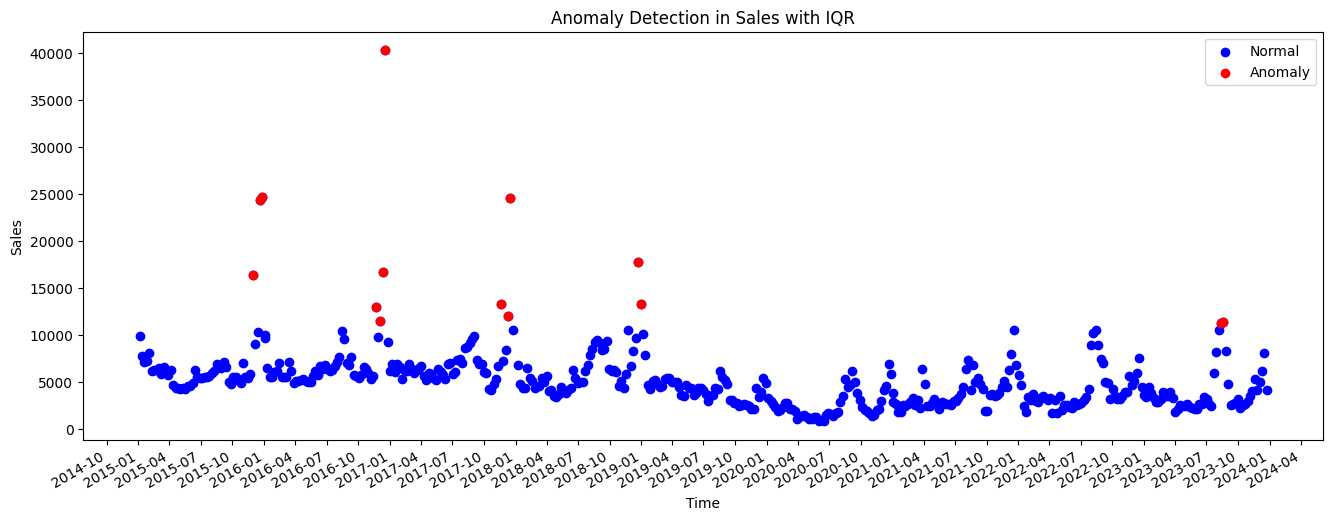

In [8]:
plt.figure(figsize=(16, 6))
plt.scatter(data['Time'], data['Sales'], color='blue', label='Normal')
plt.scatter(data[data['Outlier_IQR']]['Time'], data[data['Outlier_IQR']]['Sales'], color='red', label='Anomaly')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
plt.gcf().autofmt_xdate()
plt.title('Anomaly Detection in Sales with IQR')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Percentile

In [9]:
def calculate_percentile(data, feature, low, high):
    """
    Takes in data and feature and calculates the percentile of the feature
    data: dataframe
    feature: string
    low: int
    high: int

    return: two boolean arrays
    """
    percentile_low = np.percentile(data[feature], low)
    percentile_high = np.percentile(data[feature], high)

    greater_than_high = data[feature] > percentile_high
    smaller_than_low = data[feature] < percentile_low

    return greater_than_high, smaller_than_low

In [10]:
greater, smaller = calculate_percentile(data, 'Sales', 5, 95)

In [11]:
data['Outlier_percentile'] = np.where(greater | smaller, True, False)

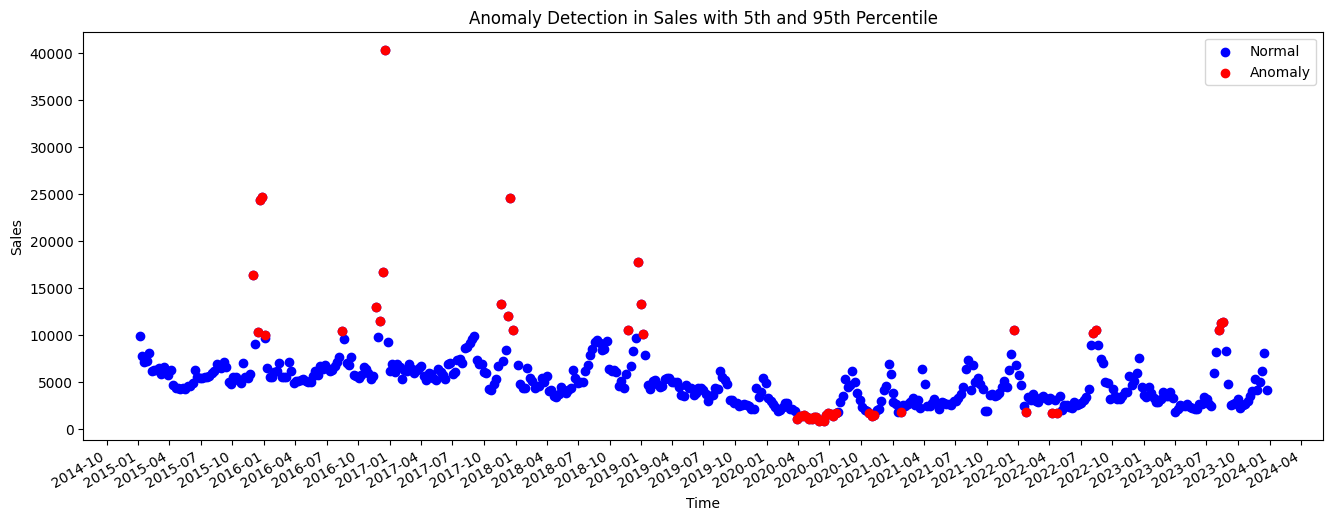

In [12]:
plt.figure(figsize=(16, 6))
plt.scatter(data['Time'], data['Sales'], color='blue', label='Normal')
plt.scatter(data[data['Outlier_percentile']]['Time'], data[data['Outlier_percentile']]['Sales'], color='red', label='Anomaly')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
plt.gcf().autofmt_xdate()
plt.title('Anomaly Detection in Sales with 5th and 95th Percentile')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# DBSCAN

In [13]:
from sklearn.cluster import DBSCAN

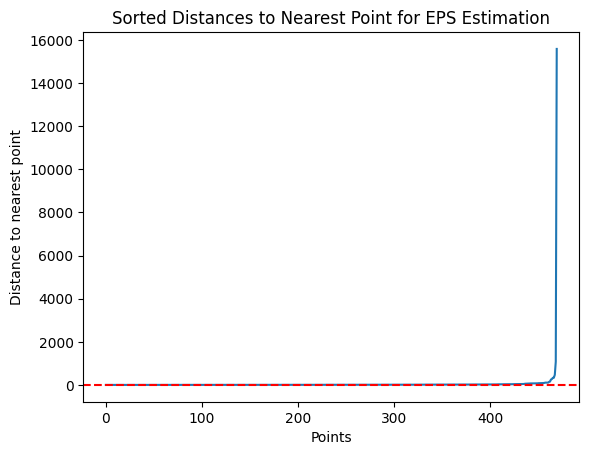

In [14]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Use NearestNeighbors to find average distance to nearest points
nearest_neighbors = NearestNeighbors(n_neighbors=3)
nearest_neighbors.fit(data[['Sales']])
distances, indices = nearest_neighbors.kneighbors(data[['Sales']])

# Sort distances and take a percentile as a starting point
sorted_distances = np.sort(distances[:, 1], axis=0)
eps_start_value = np.percentile(sorted_distances, 20)  # 20th percentile

# Plotting the sorted distances for visual inspection
plt.plot(sorted_distances)
plt.xlabel("Points")
plt.ylabel("Distance to nearest point")
plt.title("Sorted Distances to Nearest Point for EPS Estimation")
plt.axhline(y=eps_start_value, color='r', linestyle='--')
plt.show()

In [15]:
dbscan = DBSCAN(eps=450, min_samples=3)  # hyperparameters to be tuned
data['DBSCAN_Label'] = dbscan.fit_predict(data[['Sales']])

# Points labeled as -1 are outliers
data['Outlier_DBSCAN'] = data['DBSCAN_Label'] == -1

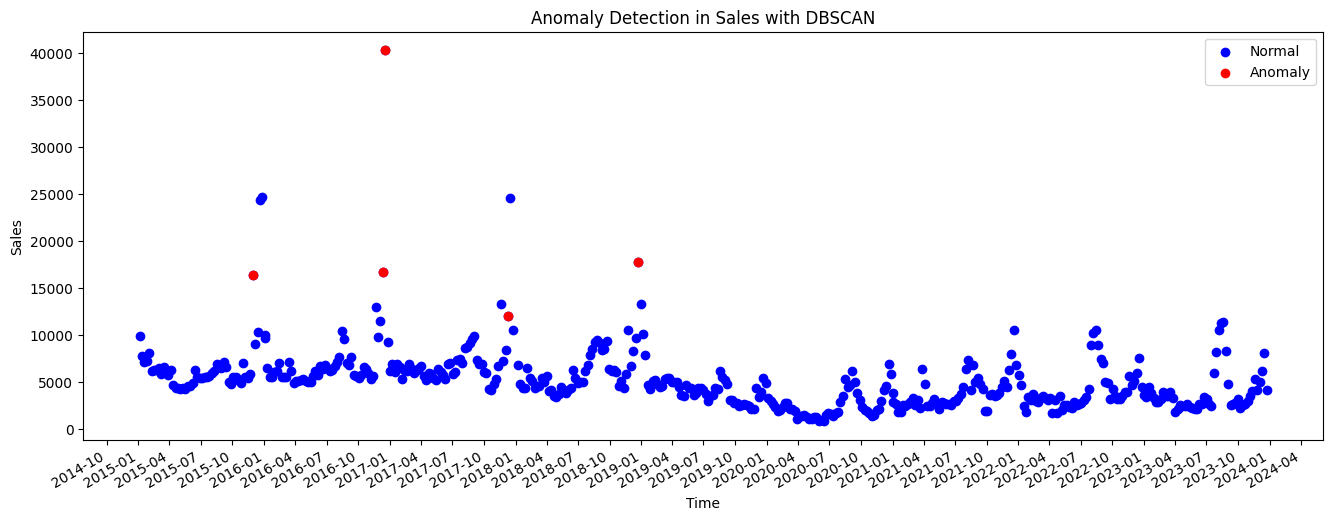

In [16]:
plt.figure(figsize=(16, 6))
plt.scatter(data['Time'], data['Sales'], color='blue', label='Normal')
plt.scatter(data[data['Outlier_DBSCAN']]['Time'], data[data['Outlier_DBSCAN']]['Sales'], color='red', label='Anomaly')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
plt.gcf().autofmt_xdate()
plt.title('Anomaly Detection in Sales with DBSCAN')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Isolation Forest

In [17]:
from sklearn.ensemble import IsolationForest

In [18]:
data['Sales_Change'] = data['Sales_Change'].fillna(method='bfill')
data['Sales_Change_percent'] = data['Sales_Change_percent'].fillna(method='bfill')

data.head()

,Series,Sales,WK_Num,MMM,Calendar Year,Fiscal Year,Sales_Change_percent,Sales_Change,Time,Sales_Log,Sales_Sqrt,Outlier_IQR,Outlier_percentile,DBSCAN_Label,Outlier_DBSCAN
0,Model110,9948,1,JAN,2015,2014,-0.213812,-2127.0,2015-01-04,9.205127,99.739661,False,False,0,False
1,Model110,7821,2,JAN,2015,2014,-0.213812,-2127.0,2015-01-11,8.964568,88.436418,False,False,0,False
2,Model110,7163,3,JAN,2015,2014,-0.084132,-658.0,2015-01-18,8.876684,84.634508,False,False,0,False
3,Model110,7262,4,JAN,2015,2014,0.013821,99.0,2015-01-25,8.890411,85.217369,False,False,0,False
4,Model110,8080,5,JAN,2015,2014,0.112641,818.0,2015-02-01,8.997147,89.888820,False,False,0,False


In [19]:
iso_forest = IsolationForest(contamination = 0.05)  # hyperparameter contamination to be tuned
data['IF_Label'] = iso_forest.fit_predict(data[['Sales']])
data['IF_sales_change'] = iso_forest.fit_predict(data[['Sales_Change']])
data['IF_sales_change_pct'] = iso_forest.fit_predict(data[['Sales_Change_percent']])

# Points labeled as -1 are outliers
data['Outlier_IF'] = data['IF_Label'] == -1
data['Outlier_IF_sales_change'] = data['IF_sales_change'] == -1
data['Outlier_IF_sales_change_pct'] = data['IF_sales_change_pct'] == -1

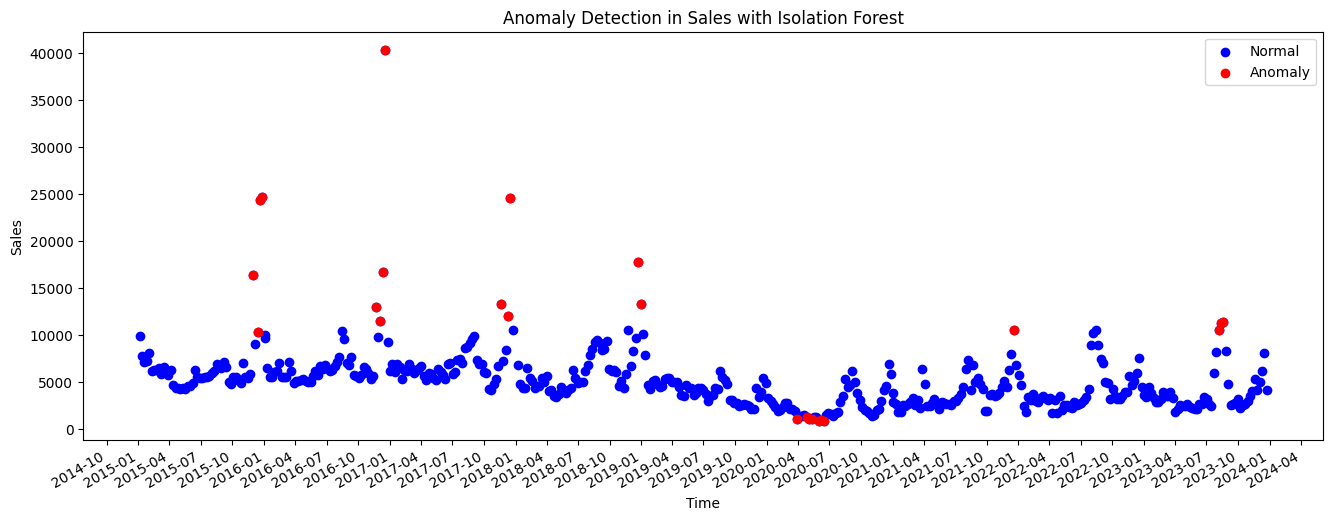

In [20]:
plt.figure(figsize=(16, 6))
plt.scatter(data['Time'], data['Sales'], color='blue', label='Normal')
plt.scatter(data[data['Outlier_IF']]['Time'], data[data['Outlier_IF']]['Sales'], color='red', label='Anomaly')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
plt.gcf().autofmt_xdate()
plt.title('Anomaly Detection in Sales with Isolation Forest')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

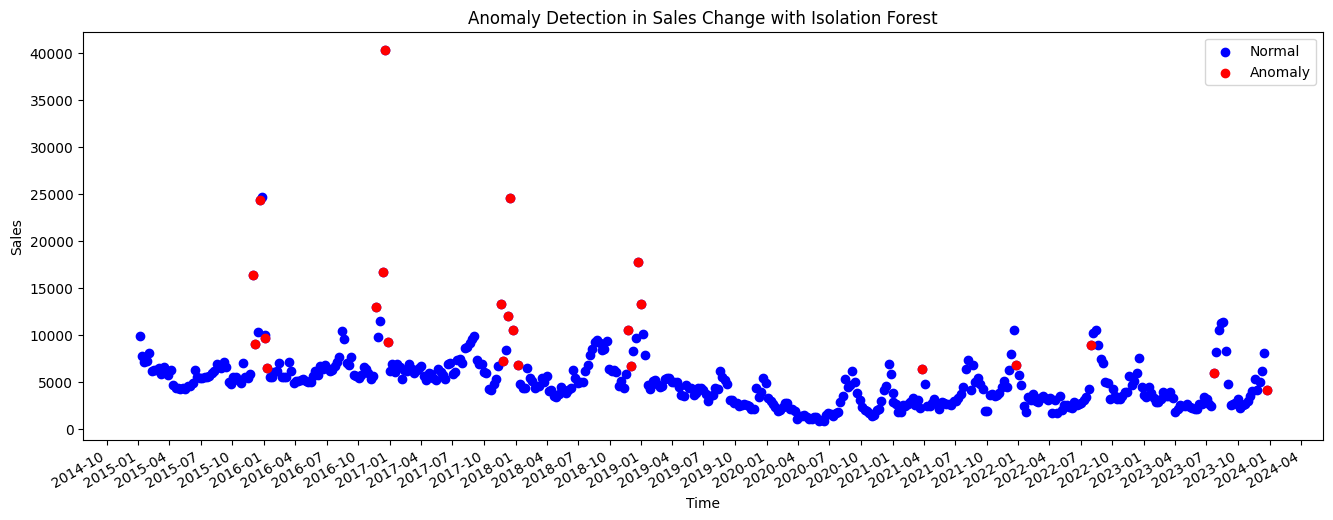

In [21]:
plt.figure(figsize=(16, 6))
plt.scatter(data['Time'], data['Sales'], color='blue', label='Normal')
plt.scatter(data[data['Outlier_IF_sales_change']]['Time'], data[data['Outlier_IF_sales_change']]['Sales'], color='red', label='Anomaly')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
plt.gcf().autofmt_xdate()
plt.title('Anomaly Detection in Sales Change with Isolation Forest')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

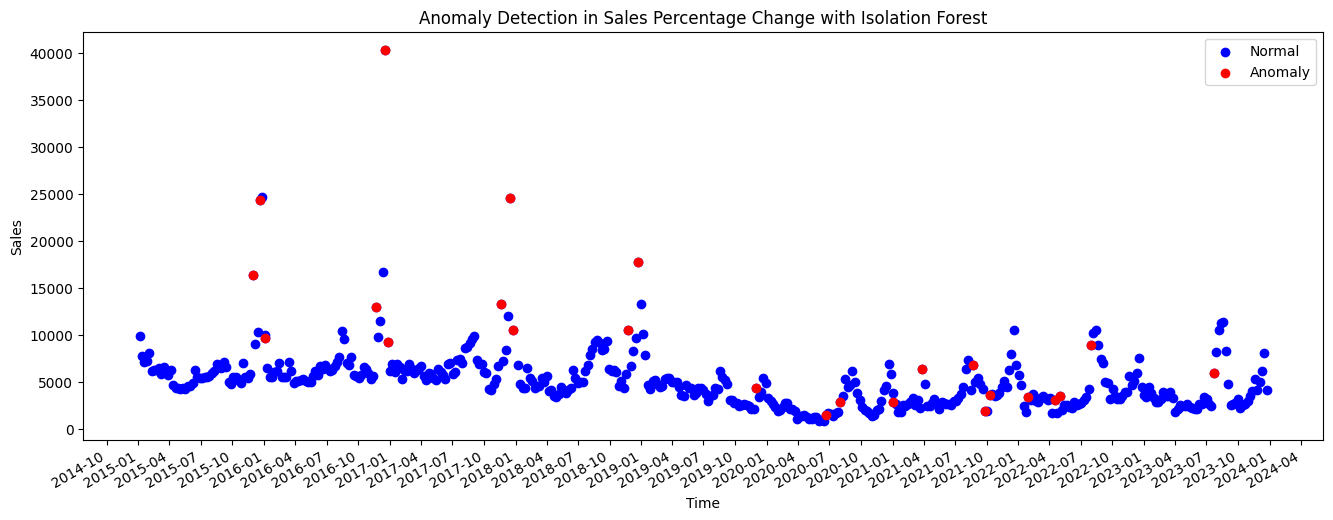

In [22]:
plt.figure(figsize=(16, 6))
plt.scatter(data['Time'], data['Sales'], color='blue', label='Normal')
plt.scatter(data[data['Outlier_IF_sales_change_pct']]['Time'], data[data['Outlier_IF_sales_change_pct']]['Sales'], color='red', label='Anomaly')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
plt.gcf().autofmt_xdate()
plt.title('Anomaly Detection in Sales Percentage Change with Isolation Forest')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Local Outlier Factor

In [23]:
from sklearn.neighbors import LocalOutlierFactor

In [42]:
lof = LocalOutlierFactor(n_neighbors=40)  # hyperparameter, n_neighbors to be tuned. Lower values are more sensitive to local outliers, larger values are more sensitive to global outliers
data['LOF_Score'] = lof.fit_predict(data[['Sales']])

# Points labeled as -1 are outliers
data['Outlier_LOF'] = data['LOF_Score'] == -1

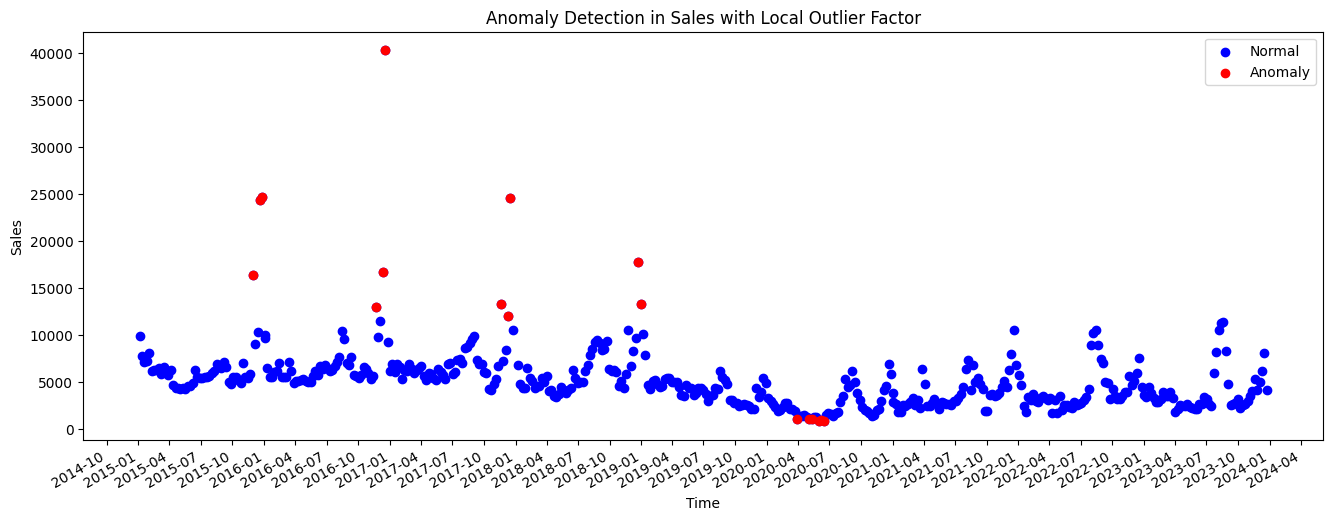

In [43]:
plt.figure(figsize=(16, 6))
plt.scatter(data['Time'], data['Sales'], color='blue', label='Normal')
plt.scatter(data[data['Outlier_LOF']]['Time'], data[data['Outlier_LOF']]['Sales'], color='red', label='Anomaly')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
plt.gcf().autofmt_xdate()
plt.title('Anomaly Detection in Sales with Local Outlier Factor')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [26]:
data[(data['Outlier_IF'] == True) | (data['Outlier_LOF'] == True) | (data['Outlier_IQR'] == True) | (data['Outlier_percentile'] == True)].head()

,Series,Sales,WK_Num,MMM,Calendar Year,Fiscal Year,Sales_Change_percent,Sales_Change,Time,Sales_Log,...,DBSCAN_Label,Outlier_DBSCAN,IF_Label,IF_sales_change,IF_sales_change_pct,Outlier_IF,Outlier_IF_sales_change,Outlier_IF_sales_change_pct,LOF_Score,Outlier_LOF
47,Model110,16362,48,NOV,2015,2015,1.803152,10525.0,2015-11-29,9.702717,...,-1,True,-1,-1,-1,True,True,True,-1,True
49,Model110,10364,50,DEC,2015,2015,0.147222,1330.0,2015-12-13,9.246094,...,0,False,-1,1,1,True,False,False,1,False
50,Model110,24350,51,DEC,2015,2015,1.349479,13986.0,2015-12-20,10.100287,...,1,False,-1,-1,-1,True,True,True,-1,True
51,Model110,24729,52,DEC,2015,2015,0.015565,379.0,2015-12-27,10.115732,...,1,False,-1,1,1,True,False,False,-1,True
53,Model110,10056,1,JAN,2016,2015,0.034887,339.0,2016-01-03,9.215925,...,0,False,1,1,1,False,False,False,1,False


In [28]:
from anomaly_dashboard import calculate_majority_voting

In [44]:
"""
Custom function to calculate majority voting, which creates an additional column in the dataframe.
It will flag a data point as an outlier if it is flagged as an outlier based on the threshold. In the below example, it is 50%
"""

# calculate majority voting
calculate_majority_voting(data, threshold=50)

# show data where majority voting is true
data[data['Outlier_Majority'] == True].head()

,Series,Sales,WK_Num,MMM,Calendar Year,Fiscal Year,Sales_Change_percent,Sales_Change,Time,Sales_Log,...,IF_Label,IF_sales_change,IF_sales_change_pct,Outlier_IF,Outlier_IF_sales_change,Outlier_IF_sales_change_pct,LOF_Score,Outlier_LOF,Sum_of_Anomalies,Outlier_Majority
47,Model110,16362,48,NOV,2015,2015,1.803152,10525.0,2015-11-29,9.702717,...,-1,-1,-1,True,True,True,-1,True,4,True
49,Model110,10364,50,DEC,2015,2015,0.147222,1330.0,2015-12-13,9.246094,...,-1,1,1,True,False,False,1,False,2,True
50,Model110,24350,51,DEC,2015,2015,1.349479,13986.0,2015-12-20,10.100287,...,-1,-1,-1,True,True,True,-1,True,4,True
51,Model110,24729,52,DEC,2015,2015,0.015565,379.0,2015-12-27,10.115732,...,-1,1,1,True,False,False,-1,True,4,True
99,Model110,13009,47,NOV,2016,2016,1.293952,7338.0,2016-11-20,9.473397,...,-1,-1,-1,True,True,True,-1,True,4,True


In [27]:
# save data to pickle file
data.to_pickle('sales_data_anomaly.pkl')

# Conclusion

The application of various anomaly detection techniques, ranging from statistical methods like IQR and Percentile based approaches, to machine learning algorithms such as Isolation Forest and Local Outlier Factor, has provided us with a data driven approach of what constitutes an anomaly in the context of our dataset. 

<br>

<b>Future work/enhancements to be considered - </b>

Domain knowledge or creation of additional feature for known events. 
For example, a simple binary feature representing external events such as promotional events/global events (such as COVID) could help improve the model.

We could also explore into manual labelling of data points that we deem as anomalies to leverage on supervised learning techniques.

Rule based system in addition to the models -
Example, if there is a sales spike during promotional events > do not flag as anomaly

<br>

Creation of an interactive dashboard using Streamlit, which not only visualized the anomalies but also provided a user-friendly interface for exploring the the model's predictions. 

This helps into making data actionable and insights accessible.